Выгрузим результаты и разобъём для каждой строки попарно

In [1]:
import sqlite3

In [2]:
conn = sqlite3.connect('Swadesh.db', check_same_thread=False)
cur = conn.cursor()

Получим список имеющихся списков

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
lists = [list[0] for list in cur.fetchall() if list[0][0].isupper()]

Получим пары из размеченного материала

In [4]:
cognations = []

for table in lists:
    cur.execute(f"SELECT * FROM {table} WHERE state=1;")
    lines = cur.fetchall()
    for line in lines:
        words = []
        for el in line[2:]:
            if el:
                for word in el.split('  '):
                    if len(word) > 3:
                        words.append(word)

    # избавимся от дубликатов
        words = list(set(words))

    # соберём пары
        for n, i in enumerate(words):
            for j in words[n+1:]:
                cognations.append([i[:-2], j[:-2], i.split()[1] == j.split()[1]])

Узнаем, сколько пар слов с проставленной когнацией у нас получилось

In [5]:
len(cognations)

51676

Запишем пары в csv

In [6]:
import csv

In [7]:
with open('pairs.csv', 'w', encoding='UTF-16', newline='') as csvfile:
    w = csv.writer(csvfile, delimiter=';')
    w.writerows(cognations)

In [332]:
with open('pairs.csv', 'r', encoding='UTF-16', newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=';')
    data = []
    y = []
    for row in r:
        data.append([row[0], row[1]])
        y.append(True if row[2] == 'True' else False)

Проверем данные на сбаллансированность

In [333]:
s = 0

for ss in y:
    if ss:
        s += 1
        
print(s/len(y))

0.4968070284077715


Латинизируем кириллицу

In [334]:
import re

In [335]:
cyr = []

for pair in data:
    for sym in set(re.findall('[\u0400-\u04FF]', pair[0])):
        cyr.append(sym)

In [336]:
cyr_to_lat = {'ь': "'", 'щ': 'šč', 'ж': 'ž', 'у': 'u',
              'а': 'a', 'й': 'j', 'ц': 'c', 'ѕ': 's', 
              'ъ': "'", 'н': 'n', 'ї': 'ji', 'ы': 'y', 
              'л': 'l', 'с': 's', 'з': 'z', 'џ': 'dj', 
              'о': 'o', 'ү': 'ü', 'к': 'k', 'ю': 'yu', 
              'т': 't', 'я': 'ja', 'і': 'i', 'м': 'm',
              'ш': 'š', 'ө': 'ö', 'ф': 'f', 'э': 'e', 
              'и': 'i', 'ќ': 'k', 'р': 'r', 'ґ': 'g', 
              'е': 'je', 'п': 'p', 'ѓ': 'gh', 'ч': 'č', 
              'є': 'je', 'г': 'g', 'б': 'b', 'ј': 'j', 
              'д': 'd', 'ў': 'w', 'ё': 'jo', 'х': 'h', 
              'в': 'v'}

In [337]:
tr = str.maketrans(cyr_to_lat)

latinized_data = [[p[0].translate(tr), p[1].translate(tr)] for p in data]

Уберём диакритику 

In [338]:
syms = []

for pair in latinized_data:
    for sym in pair[0] + pair[1]:
        syms.append(sym)

syms = set(syms)

In [339]:
import unidecode

In [340]:
del_diacr = {}

for sym in set(syms):
    del_diacr[sym] = unidecode.unidecode(sym).lower()

In [341]:
dd = str.maketrans(del_diacr)

latinized_data = [[p[0].translate(dd), p[1].translate(dd)] for p in latinized_data]

Соберём словарь с нумерацией символов

In [342]:
symss = []

for pair in latinized_data:
    for sym in pair[0] + pair[1]:
        symss.append(sym)

dict_syms = {c: i for i, c in enumerate(set(symss))}
dict_syms['<SOS>'] = 34

In [74]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [80]:
import torch

C:\Users\Imp136\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


создаётся класс нейросети с двумя слоями: рекурентный и линейный
в рекурентный слой передаюстся one-hot вектора для каждой пары слов
используется скрытое состояние рекурентной нейросети, чтобы подать его в линейный слой
после этого берётся сигмоида

In [318]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size=36, hidden_size=32, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = torch.nn.Linear(in_features=64, out_features=1)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = torch.nn.functional.one_hot(x, num_classes=36)
        x = x.double()
        x, _ = self.rnn(x, torch.zeros(2, batch_size, 32, dtype=torch.double))
        x = x[:,-1,:]
        x = self.fc(x)
        x = torch.nn.functional.sigmoid(x)
        return x

In [319]:
nn = Net()

nn = nn.double()

превращаем строки слов в список из соответсвующих им чисел, разбиввем специальным токеном

In [99]:
def to_index(pair):
    return torch.tensor([dict_syms[c] for c in pair[0]] + [dict_syms['<SOS>']] + [dict_syms[c] for c in pair[1]])

In [87]:
from sklearn.model_selection import train_test_split

разбиваем датасет на трейн и тест, загружаем в даталоадер

In [88]:
data_train, data_test, y_train, y_test = train_test_split(latinized_data, y, test_size=0.2, random_state=2)

In [101]:
mapped_train = list(map(to_index, data_train))
mapped_test = list(map(to_index, data_test))

In [255]:
dataset_train = torch.utils.data.TensorDataset(torch.nn.utils.rnn.pad_sequence(mapped_train, batch_first=True, padding_value=35), torch.tensor(list(map(float, y_train)), dtype=torch.double).reshape(-1, 1))
dataset_test = torch.utils.data.TensorDataset(torch.nn.utils.rnn.pad_sequence(mapped_test, batch_first=True, padding_value=35), torch.tensor(list(map(float, y_test)), dtype=torch.double).reshape(-1, 1))

dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=64)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=64)

In [185]:
from tqdm import tqdm

обучаем

In [320]:
optimizer = torch.optim.Adam(params=nn.parameters(), lr=0.001)
loss = torch.nn.BCELoss()

for epoch in range(30):
    running_loss = 0
    for i, data in enumerate(dl_train):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = nn(inputs)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        running_loss += l.item()
        if i % 20 == 19:
            print(running_loss / 20)
            running_loss = 0

0.6935092475042689
0.6935500956038576
0.6935749330743205
0.6937146748834648
0.6942460586836929
0.6925941494763492
0.6944250222814823
0.6934619335076526
0.6927786451754271
0.6926670287806547
0.6945256909043895
0.6927935675919905
0.6937832765811202
0.6939868171407275
0.6938373136987065
0.6936489759827327
0.6931230951299788
0.6934410129413818
0.6935168006220502
0.6920337018886235
0.694228265519157
0.6938187772987197
0.6933696921543807
0.6935306076577717
0.6932951120564612
0.6933208869184032
0.693557898217662
0.6932881415936174
0.6937887961204612
0.6926698902587509
0.6928087571512402
0.6936999430728156
0.6928688839610275
0.6935611247807115
0.6932243999600938
0.6933973078652766
0.6937868090138629
0.6927166004011551
0.6939192458074388
0.6931286660992148
0.6931712982819043
0.692730918593748
0.6943388532782329
0.6926330854760834
0.6933986122729057
0.6935677661348159
0.6937661172705699
0.6925867274653531
0.6917203165386463
0.6898812228995465
0.6871468399518446
0.6831587778019682
0.6843777629310

0.4491871268190851
0.41267115069583216
0.43836306876638054
0.42492270584832487
0.4094249758014138
0.4312797752310261
0.44951336143209425
0.46313838914735045
0.45577258569873413
0.4375151689861948
0.4499990155295207
0.4593510039006471
0.4406353158871409
0.439215209321201
0.4539690203297175
0.4822011280407863
0.45262442340029174
0.4697604392809106
0.45054855356518403
0.4356360916086361
0.4679733124887532
0.43236124001558796
0.41947435390928867
0.4309514624653975
0.45881077381295404
0.39494883440371475
0.4535343819636844
0.47204060717374396
0.43829178475583463
0.4069975850664934
0.43621430678055306
0.4641564909179257
0.43948815359025445
0.40279536239111857
0.43239648911988626
0.4184586874290934
0.4040985651267663
0.41881350935432876
0.4312162370539044
0.4490500139406913
0.4437703926628587
0.42173950505491054
0.43973985143662964
0.43887321113573663
0.42817068916563433
0.4280730398761069
0.43770349418404875
0.47656069731160045
0.44362028696389766
0.4535423482554748
0.4424478579545477
0.4320

0.419093238473154
0.39459546164086934
0.3563335146163008
0.3554610249260924
0.3692133823039643
0.36730416100774554
0.36462704870081025
0.393807395491787
0.40488299515146
0.39126760010594636
0.40978869653235767
0.3727756711499165
0.3629842417548792
0.3979959832499197
0.34970498495071867
0.3337551301961294
0.353218747399829
0.37324514789877067
0.31822560475735157
0.3800145768832736
0.39784264755582466
0.3529174341675922
0.3394343996960306
0.3357405290650207
0.39701112786372905
0.36951070422889315
0.35637609729545383
0.38804795349336607
0.3622237942001727
0.35478079001300333
0.37910768778779336
0.38598387315459715
0.4213498218349166
0.388023697050921
0.359111760230356
0.34496755991605793
0.3672908575053743
0.3653569962932771
0.3612376975816579
0.3823879940867698
0.40020399160049636
0.3786118741621666
0.4023756591364986
0.3640557105549723
0.3554150379776221
0.38871977767323873
0.35494969579703756
0.3331731578493799
0.3557403860307143
0.3804254480644663
0.3221283588948266
0.3734841162162991

смотрим на метрики

In [322]:
scores = []
targets = []
nn.eval()

for data in dl_test:
    inputs, labels = data
    outputs = nn(inputs)
    scores += outputs.tolist()
    targets += labels.tolist()

In [323]:
scores = np.array(scores).flatten()
targets = np.array(targets).flatten()

In [324]:
roc_auc_score(targets, scores)

0.7443496787722895

Получаем roc auc 0.74, плохо, попробуем варианты без обучения модели

проанализируем пересечение нграмам букв

In [326]:
import seaborn as sns
import nltk
import pandas as pd

In [328]:
def w_to_n(word):
    ngram = nltk.ngrams(list(word), 1)
    return [''.join(x) for x in ngram]

In [329]:
new_data = [set(w_to_n(p[0])) & set(w_to_n(p[1])) for p in latinized_data]

<AxesSubplot: xlabel='x', ylabel='Count'>

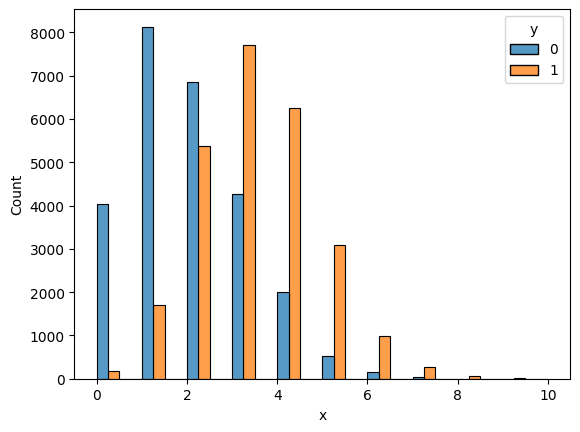

In [353]:
positive = []
negative = []

for n, el in enumerate(new_data):
    if y[n]:
        positive.append(len(el))
    else:
        negative.append(len(el))

df = pd.DataFrame({'x': positive + negative, 'y': [1] * len(positive) + [0] * len(negative)})

sns.histplot(data=df, x='x', hue='y', multiple='dodge', binwidth=0.5)

Посмотрим на нормализованное расстояние Левенштейна

In [354]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()

In [355]:
new_data = [normalized_levenshtein.similarity(*p) for p in latinized_data]

In [69]:
import pandas as pd

<AxesSubplot: xlabel='x', ylabel='Density'>

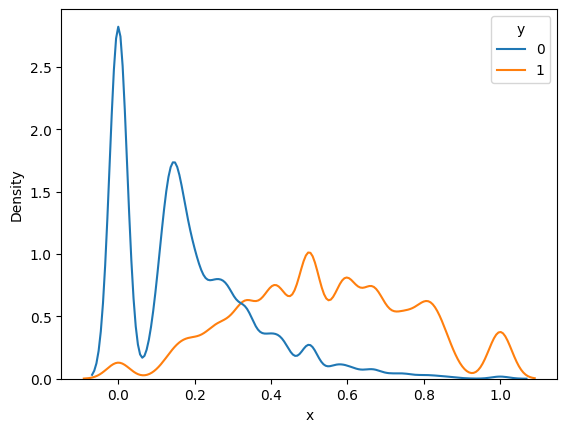

In [357]:
positive = []
negative = []

for n, el in enumerate(new_data):
    if y[n]:
        positive.append(el)
    else:
        negative.append(el)

df = pd.DataFrame({'x': positive + negative, 'y': [1] * len(positive) + [0] * len(negative)})

sns.kdeplot(data=df, x='x', hue='y')

In [359]:
scores = []

for x in range(1000):
    new_test = [p > x/1000 for p in new_data]
    scores.append(accuracy_score(y, new_test))

print(max(scores))

0.8239801842247853


In [360]:
import numpy as np

In [361]:
np.array(scores).argmax()

308

Таким образом получаем точность 0.82, что выше, чем у модели RNN